# Training a Species Detection Model in Amazon SageMaker

## Introduction

Object detection is the process of identifying and localizing objects in an image. A typical object detection solution takes an image as input and provides a bounding box on the image where an object of interest is found.  It also identifies what type of object the box encapsulates.  To create such a solution, we need to acquire and process a traning dataset, create and setup a training job for the alorithm so that it can learn about the dataset. Finally, we can then host the trained model in an endpoint, to which we can supply images.

This notebook demonstrates the use of the SageMaker Built-in Object Detection algoritm to detect animals in images. We will use a dataset labelled through Amazon SageMaker Ground Truth and we will use the "augmented manifest" file produced by Amazon SageMaker Ground Truth as an output of the labelling job. Ground Truth is a fully managed data labeling service that makes it easy to build highly accurate training datasets for machine learning. We labelled Eagles, Wallabies, Quokkas, Possums and Wombats on hundreds of images, to then train an object detection machine learning model with AWS SageMaker.

Amazon SageMaker's object detection algorithm uses the Single Shot multibox Detector ([SSD](https://arxiv.org/abs/1512.02325)) algorithm, and this notebook uses a [ResNet](https://arxiv.org/pdf/1603.05027.pdf) base network with that algorithm.

<div>
<center>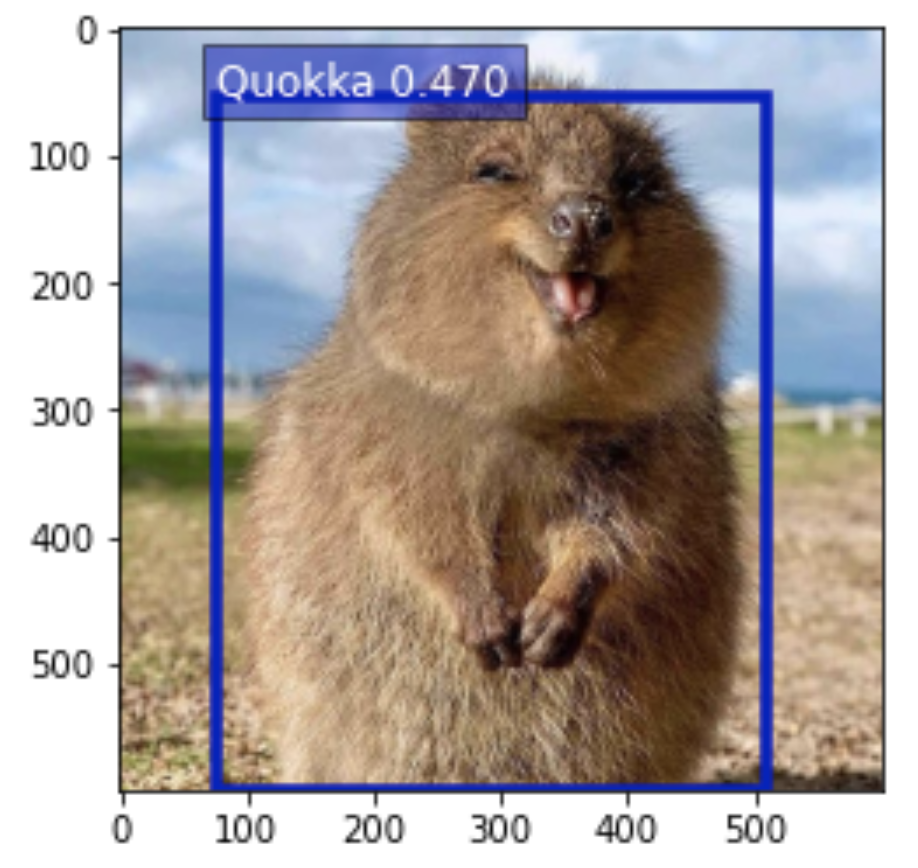<center>
</div>


### Setup Amazon SageMaker

Let's start by specifying:


- We need an AWS account role with SageMaker access. Here we will use the execution role the current notebook instance was given when it was created.  This role has necessary permissions, including access to your data in S3. The IAM role arn used to give training and hosting access to your data.

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting. In this case, we will use the default S3 bucket.


In [1]:
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
import time
from time import gmtime, strftime
import json

role = get_execution_role()
sess = sagemaker.Session()
s3 = boto3.resource('s3')
bucket_output = sess.default_bucket() 

We also get the URI to the Amazon SageMaker Object Detection docker image.  This ensures the estimator uses the correct algorithm from the current region.

In [2]:
training_image = sagemaker.amazon.amazon_estimator.get_image_uri(boto3.Session().region_name, 'object-detection', repo_version='latest')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.



### Required Inputs

We will need specify the location of the manifest file which contains the images and their annotations.

In [3]:
augmented_manifest_filename_train = 'output.manifest' 
bucket_name = "ala-animal-images"
s3_prefix = 'ala-animal-classification-chain2/manifests/output'
s3_output_path = 's3://{}/output'.format(bucket_output) 

At this stage, we have fully labeled our dataset and we can train a machine learning model to perform object detection. We'll do so using the **augmented manifest** output of our labeling job - no additional file translation or manipulation required! For a more complete description of the augmented manifest, see our other [example notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/ground_truth_labeling_jobs/object_detection_augmented_manifest_training/object_detection_augmented_manifest_training.ipynb).

**NOTE:** Object detection is a complex task, and training neural networks to high accuracy requires large datasets and careful hyperparameter tuning. The following cells illustrate how to train a neural network using a Ground Truth output augmented manifest, and how to interpret the results. However, we shouldn't expect a network trained on 100 or 1000 images to do a phenomenal job on unseen images!

First, we'll split our augmented manifest into a training set and a validation set using an 90/10 split and save the results to files that the model will use during training.

In [4]:
s3_data_path = 's3://{}/{}/{}'.format(bucket_name, s3_prefix, augmented_manifest_filename_train)

### Split the manifest file into training and validation set

augmented_manifest_s3_key = s3_data_path.split(bucket_name)[1][1:]
s3_obj = s3.Object(bucket_name, augmented_manifest_s3_key)
augmented_manifest = s3_obj.get()['Body'].read().decode('utf-8')
augmented_manifest_lines = augmented_manifest.split('\n')

import random
random.shuffle(augmented_manifest_lines)

augmented_manifest_lines = list(filter(None, augmented_manifest_lines))

num_training_samples = len(augmented_manifest_lines) # Compute number of training samples for use in training job request.
split = int(num_training_samples*0.9)

augmented_manifest_filename_train = 'manifest/augmented-manifest-train.manifest'
augmented_manifest_filename_validation = 'manifest/augmented-manifest-validation.manifest'
client = boto3.client('s3')
response = client.put_object( 
    Bucket=bucket_output,
    Body='\n'.join(augmented_manifest_lines[0:split]),
    Key=augmented_manifest_filename_train
)
client = boto3.client('s3')
response = client.put_object( 
    Bucket=bucket_output,
    Body='\n'.join(augmented_manifest_lines[split+1:]),
    Key=augmented_manifest_filename_validation
)

s3_train_data_path = 's3://{}/{}'.format(bucket_output, augmented_manifest_filename_train)
s3_validation_data_path = 's3://{}/{}'.format(bucket_output, augmented_manifest_filename_validation)

print("Augmented manifest for training data: {}".format(s3_train_data_path))
print("Augmented manifest for validation data: {}".format(s3_validation_data_path))

Augmented manifest for training data: s3://sagemaker-ap-southeast-2-343812647137/manifest/augmented-manifest-train.manifest
Augmented manifest for validation data: s3://sagemaker-ap-southeast-2-343812647137/manifest/augmented-manifest-validation.manifest


### Understanding the Augmented Manifest format

Augmented manifests provide two key benefits. First, the format is consistent with that of a labeling job output manifest. This means that you can take your output manifests from a Ground Truth labeling job and, whether the dataset objects were entirely human-labeled, entirely machine-labeled, or anything in between, and use them as inputs to SageMaker training jobs - all without any additional translation or reformatting! Second, the dataset objects and their corresponding ground truth labels/annotations are captured *inline*. This effectively reduces the required number of channels by half, since you no longer need one channel for the dataset objects alone and another for the associated ground truth labels/annotations.

The augmented manifest format is essentially the [json-lines format](http://jsonlines.org/), also called the new-line delimited JSON format. This format consists of an arbitrary number of well-formed, fully-defined JSON objects, each on a separate line. Augmented manifests must contain a field that defines a dataset object, and a field that defines the corresponding annotation. Let's look at an example for an object detection problem.

The Ground Truth output format is discussed more fully for various types of labeling jobs in the [official documenation](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-data-output.html).

{<span style="color:blue">"source-ref"</span>: "s3://bucket_name/path_to_a_dataset_object.jpeg", <span style="color:blue">"labeling-job-name"</span>: {"annotations":[{"class_id":"0",`<bounding box dimensions>`}],"image_size":[{`<image size simensions>`}]}

The first field will always be either `source` our `source-ref`. This defines an individual dataset object. The name of the second field depends on whether the labeling job was created from the SageMaker console or through the Ground Truth API. If the job was created through the console, then the name of the field will be the labeling job name. Alternatively, if the job was created through the API, then this field maps to the `LabelAttributeName` parameter in the API. 

The training job request requires a parameter called `AttributeNames`. This should be a two-element list of strings, where the first string is "source-ref", and the second string is the label attribute name from the augmented manifest. This corresponds to the <span style="color:blue">blue text</span> in the example above. In this case, we would define `attribute_names = ["source-ref", "labeling-job-name"]`.

*Be sure to carefully inspect your augmented manifest so that you can define the `attribute_names` variable below.*

### Preview Input Data

Let's read the augmented manifest so we can inspect its contents to better understand the format.

In [5]:
print('Preview of Augmented Manifest File Contents')
print('-------------------------------------------')
print('\n')

for i in range(5):
    print('Line {}'.format(i+1))
    print(augmented_manifest_lines[i])
    print('\n')

Preview of Augmented Manifest File Contents
-------------------------------------------


Line 1
{"source-ref":"s3://ala-animal-images/Eagle_2892ec6b-8339-4ca1-bf42-2dbc65af4e99.jpg","ala-animal-classification-chain2":{"image_size":[{"width":1800,"height":1200,"depth":3}],"annotations":[{"class_id":0,"top":363,"left":803,"height":325,"width":281}]},"ala-animal-classification-chain2-metadata":{"objects":[{"confidence":0}],"class-map":{"0":"Eagle"},"type":"groundtruth/object-detection","human-annotated":"yes","creation-date":"2021-05-17T11:46:19.723759","job-name":"labeling-job/ala-animal-classification-chain2"}}


Line 2
{"source-ref":"s3://ala-animal-images/Wombat_053dc7fb-2a35-4909-8818-fe981306e876.jpg","ala-animal-classification-chain2":{"image_size":[{"width":2048,"height":1536,"depth":3}],"annotations":[{"class_id":1,"top":1041,"left":603,"height":486,"width":927}]},"ala-animal-classification-chain2-metadata":{"objects":[{"confidence":0}],"class-map":{"1":"Wombat"},"type":"groundt

The key feature of the augmented manifest is that it has both the data object itself (i.e., the image), and the annotation in-line in a single JSON object. Note that the `annotations` keyword contains dimensions and coordinates (e.g., width, top, height, left) for bounding boxes! The augmented manifest can contain an arbitrary number of lines, as long as each line adheres to this format.

Let's discuss this format in more detail by descibing each parameter of this JSON object format.

* The `source-ref` field defines a single dataset object, which in this case is an image over which bounding boxes should be drawn. Note that the name of this field is arbitrary. 
* The `object-detection-job-name` field defines the ground truth bounding box annotations that pertain to the image identified in the `source-ref` field. As mentioned above, note that the name of this field is arbitrary. You must take care to define this field in the `AttributeNames` parameter of the training job request, as shown later on in this notebook.
* Because this example augmented manifest was generated through a Ground Truth labeling job, this example also shows an additional field called `object-detection-job-name-metadata`. This field contains various pieces of metadata from the labeling job that produced the bounding box annotation(s) for the associated image, e.g., the creation date, confidence scores for the annotations, etc. This field is ignored during the training job. However, to make it as easy as possible to translate Ground Truth labeling jobs into trained SageMaker models, it is safe to include this field in the augmented manifest you supply to the training job.

In [6]:
# Determine the keys in the training manifest and exclude the meta data from the labling job.
attribute_names = list(json.loads(augmented_manifest_lines[0]).keys())
attribute_names = [attrib for attrib in attribute_names if 'meta' not in attrib]

### Create Training Job

First, we'll construct the request for the training job.
The object detection algorithm at its core is the [Single-Shot Multi-Box detection algorithm (SSD)](https://arxiv.org/abs/1512.02325). This algorithm uses a `base_network`, which is typically a [VGG](https://arxiv.org/abs/1409.1556) or a [ResNet](https://arxiv.org/abs/1512.03385). The Amazon SageMaker object detection algorithm supports VGG-16 and ResNet-50. It also has a number of hyperparameters that help configure the training job. The next step in our training, is to setup these hyperparameters and data channels for training the model. See the SageMaker Object Detection [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html) for more details on its specific hyperparameters.

We also define the data channels to be passed to the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.  Note that you could add a third channel named `model` to perform incremental training (continue training from where you had left off with a prior model).

In [7]:
try:
    if attribute_names == ["source-ref","XXXX"]:
        raise Exception("The 'attribute_names' variable is set to default values. Please check your augmented manifest file for the label attribute name and set the 'attribute_names' variable accordingly.")
except NameError:
    raise Exception("The attribute_names variable is not defined. Please check your augmented manifest file for the label attribute name and set the 'attribute_names' variable accordingly.")

# Create unique job name
job_name_prefix = 'groundtruth-augmented-manifest-demo'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp

training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": training_image, # NB. This is one of the named constants defined in the first cell.
        "TrainingInputMode": "Pipe"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": s3_output_path
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p3.2xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": { # NB. These hyperparameters are at the user's discretion and are beyond the scope of this demo.
         "base_network": "resnet-50",
         "use_pretrained_model": "1",
         "num_classes": "5",
         "mini_batch_size": "32",
         "epochs": "10",
         "optimizer": "adam",
         "image_shape": "300",
         "num_training_samples": str(num_training_samples)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "AugmentedManifestFile", # NB. Augmented Manifest
                    "S3Uri": s3_train_data_path,
                    "S3DataDistributionType": "FullyReplicated",
                    "AttributeNames": attribute_names # NB. This must correspond to the JSON field names in your augmented manifest.
                }
            },
            "ContentType": "application/x-recordio",
            "RecordWrapperType": "RecordIO",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "AugmentedManifestFile", # NB. Augmented Manifest
                    "S3Uri": s3_validation_data_path,
                    "S3DataDistributionType": "FullyReplicated",
                    "AttributeNames": attribute_names # NB. This must correspond to the JSON field names in your augmented manifest.
                }
            },
            "ContentType": "application/x-recordio",
            "RecordWrapperType": "RecordIO",
            "CompressionType": "None"
        }
    ]
}

print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: groundtruth-augmented-manifest-demo-2021-05-19-06-06-21

Input Data Location: {'S3DataType': 'AugmentedManifestFile', 'S3Uri': 's3://sagemaker-ap-southeast-2-343812647137/manifest/augmented-manifest-train.manifest', 'S3DataDistributionType': 'FullyReplicated', 'AttributeNames': ['source-ref', 'ala-animal-classification-chain2']}


The training process involves a few steps. First, the instances that we requested while creating the `Estimator` classes are provisioned and setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the actual training begins. The provisioning and data downloading will take time, depending on the size of the data. Therefore it might be a few minutes before our training job logs show up in CloudWatch. The logs will also print out Mean Average Precision (mAP) on the validation data, among other losses, for every run of the dataset (once per epoch). This metric is a proxy for the accuracy of the model.

Once the job has finished, a `Job complete` message will be printed. The trained model artifacts can be found in the S3 bucket that was setup as `output_path` in the estimator.

In [10]:
client = boto3.client(service_name='sagemaker')
client.create_training_job(**training_params)

# Confirm that the training job has started
status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

Training job current status: InProgress


In [11]:
TrainingJobStatus = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
SecondaryStatus = client.describe_training_job(TrainingJobName=job_name)['SecondaryStatus']
print(TrainingJobStatus, SecondaryStatus)
while TrainingJobStatus !='Completed' and TrainingJobStatus!='Failed':
    time.sleep(60)
    TrainingJobStatus = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    SecondaryStatus = client.describe_training_job(TrainingJobName=job_name)['SecondaryStatus']
    print(TrainingJobStatus, SecondaryStatus)

InProgress Starting
InProgress Starting
InProgress Starting
InProgress Training
InProgress Training
InProgress Training
InProgress Training
InProgress Training
InProgress Training
InProgress Training
InProgress Training
InProgress Training
InProgress Training
InProgress Training
InProgress Training
InProgress Uploading
Completed Completed


Now that the training job is complete, you can also see the job listed in the `Training jobs` section of your SageMaker console.  Note that the job name is uniquely identified by the name of the algorithm concatenated with the date and time stamp.  You can click on the job to see the details including the hyperparameters, the data channel definitions, and the full path to the resulting model artifacts.  You could even clone the job from the console, and tweak some of the parameters to generate a new training job.

Without having to go to the CloudWatch console, you can see how the job progressed in terms of the key object detection algorithm metric, mean average precision (mAP).  This function below prepares a simple chart of that metric against the epochs.

In [14]:
training_info = client.describe_training_job(TrainingJobName=job_name)
print(training_info)

{'TrainingJobName': 'groundtruth-augmented-manifest-demo-2021-05-19-06-06-21', 'TrainingJobArn': 'arn:aws:sagemaker:ap-southeast-2:343812647137:training-job/groundtruth-augmented-manifest-demo-2021-05-19-06-06-21', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-ap-southeast-2-343812647137/output/groundtruth-augmented-manifest-demo-2021-05-19-06-06-21/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'base_network': 'resnet-50', 'epochs': '10', 'image_shape': '300', 'mini_batch_size': '32', 'num_classes': '5', 'num_training_samples': '1555', 'optimizer': 'adam', 'use_pretrained_model': '1'}, 'AlgorithmSpecification': {'TrainingImage': '544295431143.dkr.ecr.ap-southeast-2.amazonaws.com/object-detection:1', 'TrainingInputMode': 'Pipe', 'MetricDefinitions': [{'Name': 'train:progress', 'Regex': '#progress_metric: host=\\S+, completed (\\S+) %'}, {'Name': 'train:smooth_l1', 'Regex': '#quality_metric: host=\\S+, epoch=\\S+, ba

Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This lets us make predictions (or inferences) from the model. Note that we don't have to host using the same type of instance that we used to train. Training is a prolonged and compute heavy job with different compute and memory requirements that hosting typically does not. In our case we chose the `ml.p3.2xlarge` instance to train, but we choose to host the model on the less expensive cpu instance, `ml.m4.xlarge`. The endpoint deployment takes several minutes, and can be accomplished with a single line of code calling the `deploy` method.

In [15]:
!wget http://d1uvw90uyir5vw.cloudfront.net/atlas/model.tar.gz
!aws s3 cp ./model.tar.gz s3://{bucket_output}/atlas/model.tar.gz

model_path = f's3://{bucket_output}/atlas/model.tar.gz'
#model_path = training_info['ModelArtifacts']['S3ModelArtifacts']
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_name='groundtruth-demo-od-model' + timestamp
print(model_name)
model_data = training_info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': training_image,
    'ModelDataUrl': model_data,
}

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

--2021-05-19 06:27:28--  http://d1uvw90uyir5vw.cloudfront.net/atlas/model.tar.gz
Resolving d1uvw90uyir5vw.cloudfront.net (d1uvw90uyir5vw.cloudfront.net)... 13.226.74.119, 13.226.74.47, 13.226.74.72, ...
Connecting to d1uvw90uyir5vw.cloudfront.net (d1uvw90uyir5vw.cloudfront.net)|13.226.74.119|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179172913 (171M) [application/x-gzip]
Saving to: ‘model.tar.gz’

model.tar.gz        100%[===================>] 170.87M  84.7MB/s    in 2.0s    

2021-05-19 06:27:30 (84.7 MB/s) - ‘model.tar.gz’ saved [179172913/179172913]

upload: ./model.tar.gz to s3://sagemaker-ap-southeast-2-343812647137/atlas/model.tar.gz
groundtruth-demo-od-model-2021-05-19-06-27-33
s3://sagemaker-ap-southeast-2-343812647137/output/groundtruth-augmented-manifest-demo-2021-05-19-06-06-21/output/model.tar.gz
arn:aws:sagemaker:ap-southeast-2:343812647137:model/groundtruth-demo-od-model-2021-05-19-06-27-33


In [16]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc' + timestamp
endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: groundtruth-augmented-manifest-demo-epc-2021-05-19-06-27-34
Endpoint configuration arn:  arn:aws:sagemaker:ap-southeast-2:343812647137:endpoint-config/groundtruth-augmented-manifest-demo-epc-2021-05-19-06-27-34


In [17]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = client.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

# get the status of the endpoint
response = client.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))

# wait until the status has changed
client.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)

# print the status of the endpoint
endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

Endpoint name: groundtruth-augmented-manifest-demo-ep-2021-05-19-06-27-34
EndpointArn = arn:aws:sagemaker:ap-southeast-2:343812647137:endpoint/groundtruth-augmented-manifest-demo-ep-2021-05-19-06-27-34
EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


### Test the model

Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference.  The results of a call to the inference endpoint are in a format that is similar to the .lst format, with the addition of a confidence score for each detected object. The format of the output can be represented as `[class_index, confidence_score, xmin, ymin, xmax, ymax]`. Typically, we don't visualize low-confidence predictions.

We have provided a script to easily visualize the detection outputs. You can visulize the high-confidence preditions with bounding box by filtering out low-confidence detections using the script below:

In [18]:
import json
import numpy as np
runtime = boto3.Session().client(service_name='runtime.sagemaker')

def predict(file_name):
    with open(file_name, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)
    response = runtime.invoke_endpoint(EndpointName=endpoint_name,
                                       #ContentType='image/jpeg',
                                       ContentType='application/x-image',
                                       Body=payload)

    # result will be in json format and convert it to ndarray
    detections = json.loads(response['Body'].read())
    return detections

In [19]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                #print(int(klass))
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

In [20]:
#file_name = 'Eagle_0263a6d8-18eb-496e-a519-c73cb4ac9cb2.jpg'
#file_name = 'Possum_59d8d61a-0ce4-4b02-820c-7a0f2b91ddb6.jpg'
file_name = 'Wallaby_36656b44-0ff9-418c-a6d8-61b82933eceb.jpg'
#file_name = 'Qokka_7d5e6ca6-09a0-4e74-a888-8b3a750c3a93.jpg'
#file_name = '85049182-the-quokka-and-swamp-wallaby-are-friends.jpg'
#file_name = 'tjVqpja6.jpg'
#file_name = 'Image-by-@wildlife.photography-BLOG.jpg'

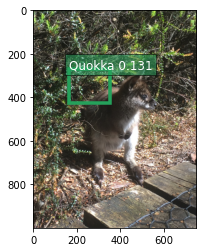

In [25]:
object_categories = ['Eagle', 'Wombat', 'Quokka', 'Wallaby','Possum']

# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.13

detections = predict(file_name)
# Visualize the detections.
visualize_detection(file_name, detections['prediction'], object_categories, threshold)